In [1]:
import os
import pandas as pd
from collections import defaultdict

import matplotlib.pyplot as plt
from upsetplot import UpSet

In [2]:
## Some utility functions
def get_circminer(circ_file, min_ccr=1):
    names=["chrom", "start", "end", "nccr", "type", "cons_splice", "splice", "pass", "supp_reads"]
    circrnas = pd.read_csv(circ_file, sep="\t", names=names)
    circrnas = circrnas[circrnas['nccr']>=min_ccr]
    return circrnas.sort_values(["chrom", "start"])

def get_circeplorer(circ_file, min_ccr=1):
    names=["chrom", "start", "end", "name", "score", "strand", "thickStart", 
           "thickEnd", "itemRgb", "exonCount", "exonSizes", "exonOffsets", 
           "readNumber", "circType", "geneName", "isoformName", "exonIndex/intronIndex", 
           "flankIntron"]
    circrnas = pd.read_csv(circ_file, sep="\t", names=names)
    circrnas['start'] = circrnas['start'] + 1
    circrnas = circrnas.rename(columns={"readNumber": "nccr"})
    circrnas = circrnas[circrnas['nccr']>=min_ccr]
    return circrnas.sort_values(["chrom", "start"])

def get_circeplorer2(circ_file, min_ccr=1):
    return get_circeplorer(circ_file, min_ccr)

def get_dcc(circ_file, min_ccr=1):
    circrnas = pd.read_csv(circ_file, sep="\t")
    circrnas = circrnas.rename(columns={"Chr": "chrom", "Start": "start", "End": "end", 
                                        "Chimeric.out.junction": "nccr"})
    circrnas = circrnas[circrnas['nccr']>=min_ccr]
    return circrnas.sort_values(["chrom", "start"])

def get_cirminer(circ_file, min_ccr=1):
    names=["chrom","start","end","nccr","type","cons_splice", "splice", "pass", "supp_reads"]
    circrnas = pd.read_csv(circ_file, sep="\t", names=names)
    circrnas = circrnas = circrnas[circrnas['nccr']>=min_ccr]
    return circrnas.sort_values(["chrom", "start"])


def get_auzeville(circ_file, min_ccr=1):
    names=["chrom","start","end", "id", "score","strand", "tool", "type", "what", "infos"]
    circrnas = pd.read_csv(circ_file, sep="\t", names=names)
    circrnas['start'] = circrnas['start'] + 1
    circrnas['nb_ccr'] = circrnas.infos.str.extract(r'^nb_ccr=(\d+)\;', expand=True)
    circrnas['nb_ccr'] = pd.to_numeric(circrnas['nb_ccr'])
    circrnas = circrnas[circrnas['nb_ccr']>=min_ccr]
    return circrnas.sort_values(["chrom", "start"])


def set_key(record):
    return "-".join(map(str, [record["chrom"], record["start"], record["end"]]))

def get_keys(circrnas):
    circrnas_dict = defaultdict()
    for index, row in circrnas.iterrows():
        circrnas_dict[set_key(row)] = row
    circ_keys = set(circrnas_dict.keys())
    return circ_keys

def get_all_keys(circrnas):
    circ_keys = defaultdict()
    for tool, circs in circrnas.items():
        circ_keys[tool] = get_keys(circs)
    return circ_keys

def get_circ_fromtool(circ_file, tool, min_ccr=1):
    if tool == "circexplorer":
        return get_circeplorer(circ_file, min_ccr)
    if tool == "circexplorer2":
        return get_circeplorer2(circ_file, min_ccr)
    if tool == "circminer":
        return get_circminer(circ_file, min_ccr)
    if tool == "dcc":
        return get_dcc(circ_file, min_ccr)
    if tool == "auzeville":
        return get_auzeville(circ_file, min_ccr)

def getRNaseCirc(sample, tools, min_ccr=1):
    circrnas = defaultdict()
    for tool_str in tools:
        tool = tool_str.lower()
        circ_file = os.path.join("circrnas", sample, tool.lower()+".out")
        print("Reading %s" % circ_file)
        circrnas[tool_str] = get_circ_fromtool(circ_file, tool, min_ccr)   
    return circrnas

def get_support(circrnas):
    circ_keys = get_all_keys(circrnas)
    sorted_tools = sorted(circ_keys.keys())
    all_ids = set.union(*circ_keys.values())
    tool_support = []
    for circ in all_ids:
        counter = [True]
        for tool in sorted_tools:
            counter.append(True if circ in circ_keys[tool] else False)
        counter.append(circ)
        tool_support.append(counter)
    df = pd.DataFrame.from_records(tool_support,columns=["Union"] + sorted_tools +["id"])
    df = df.set_index(tools)
    return df

def get_not_depleted(circrnas, tools, positive, negative):
    after = get_all_keys(circrnas[positive])
    before = get_all_keys(circrnas[negative])
    sorted_tools = sorted(circrnas.keys())
    not_depleted = []
    percent_not_depleted = []
    for tool in tools:
        not_deple = after[tool] & before[tool]
        not_depleted.append(len(not_deple))
        #print("%d and %d" %(len(not_deple), len(before[tool])))
        percent_not_depleted.append(len(not_deple)/len(before[tool]))
    return {"Not depleted": not_depleted, "Not depleted (%)": percent_not_depleted}


def get_dcc_annotation(circrnas, annot_file):
    dcc_selected = get_keys(circrnas['DCC'])
    circrnas = pd.read_csv(annot_file, sep="\t")
    circrnas = circrnas.rename(columns={"Chr": "chrom", "Start": "start", "End": "end"})
    circrnas_sel = []
    for index, row in circrnas.iterrows():
        circ_key = set_key(row)
        circrnas_sel.append(circ_key in dcc_selected)
    circrnas = circrnas[circrnas_sel]
    return circrnas


def annot_pie(circrnas):
    circrnas_annot = []
    for index, row in circrnas.iterrows():
        annot = row['Start-End Region']
        reannot = "-".join(sorted(annot.split('-')))
        if ("intron" in annot or "exon" in annot) and "intergenic" in annot:
            reannot = "mixed"
        elif "intron" in annot:
            reannot = "intron"
        elif "intergenic" in annot:
            reannot = "intergenic"
        elif annot == "exon-exon":
            reannot = "exon"
        circrnas_annot.append(reannot)
    circrnas['annotation'] = circrnas_annot
    sizes = circrnas.groupby("annotation").size() 
    new_index = ['exon', 'intron', 'intergenic', 'mixed']
    sizes = sizes.reindex(index=new_index)
    import matplotlib.pyplot as plt

    # Pie chart, where the slices will be ordered and plotted counter-clockwise:
    labels = sizes.index.values
    pie_sizes = sizes.values
    explode = (0.1, 0, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

    fig1, ax1 = plt.subplots()
    ax1.pie(pie_sizes, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=False, startangle=90, labeldistance=1.4, pctdistance=1.2)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.show()

### Benchmarking the different circRNAs detection tools

- CIRCexplorer
- circminer
- DCC
- Auzeville (home made tool)

We follow the protocol of the Circminer paper : https://doi.org/10.1093/bioinformatics/btaa232

Two cell lines are studied : 
  - HeLa and Hs68

Quoting the Circminer paper:

> For each cell line, one dataset is a typical RNA-Seq data sequenced using rRNA depletion protocol, and the other one is a treated sample where circRNAs are enriched after most linear RNA molecules are digested and removed by RNase R enzyme. 

We denote the former by HeLaR− and Hs68R−, and the latter HeLaR+ and He68R+, respectively.

See the Circminer paper for a mode detailed description.

## HeLa cell line

In [11]:
tools = ["Circminer", "CIRCexplorer", "DCC", "auzeville"]
treatments = ["HeLaR-", "HeLaR+"]
min_ccr = 3
HeLa = defaultdict()
HeLa["HeLaR-"] = getRNaseCirc("HeLaRminus",  tools, min_ccr=min_ccr)
HeLa["HeLaR+"] = getRNaseCirc("HeLaRplus",  tools, min_ccr=min_ccr)

Reading circrnas/HeLaRminus/circminer.out
Reading circrnas/HeLaRminus/circexplorer.out
Reading circrnas/HeLaRminus/dcc.out
Reading circrnas/HeLaRminus/auzeville.out
Reading circrnas/HeLaRplus/circminer.out
Reading circrnas/HeLaRplus/circexplorer.out
Reading circrnas/HeLaRplus/dcc.out
Reading circrnas/HeLaRplus/auzeville.out


In [12]:
calls = defaultdict(list)
for condition in treatments:
    for tool in tools:
        calls[condition].append(len(HeLa[condition][tool]))
calls['tool'] = tools
calls.update(get_not_depleted(HeLa, tools, "HeLaR+", "HeLaR-"))

### Detailed comparison or circ detection tools on HeLa RNase-	HeLa RNase+

In [13]:
pd.DataFrame(calls).set_index("tool")

,HeLaR-,HeLaR+,Not depleted,Not depleted (%)
tool,,,,
Circminer,3514,4399,2024,0.575982
CIRCexplorer,1811,3084,1107,0.611264
DCC,2789,3462,1462,0.524202
auzeville,4801,3839,1408,0.293333


### Tool overlap for HeLaR-

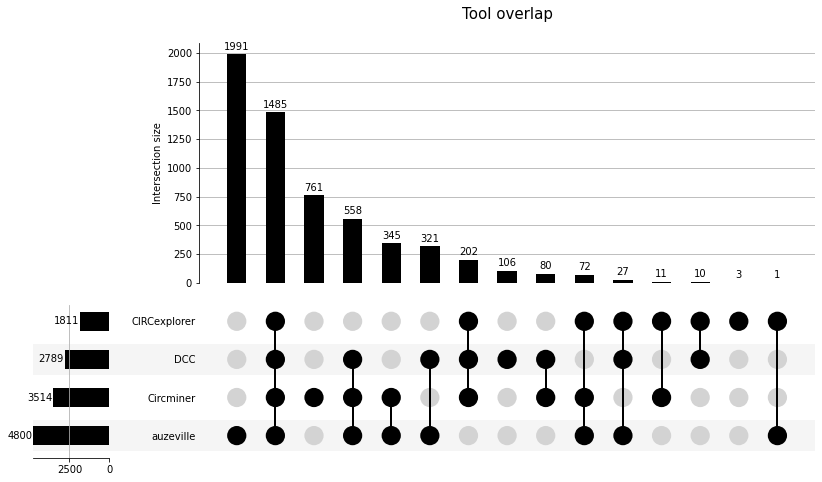

In [14]:
support = get_support(HeLa["HeLaR-"])
fig = plt.figure(figsize=(100, 20))
upset = UpSet(support, subset_size='count', sort_by="cardinality", show_counts='%d', element_size=55)
upset.plot(fig = fig)
temp = plt.title("Tool overlap\n",fontsize=15)

### Tool overlap for HeLaR+

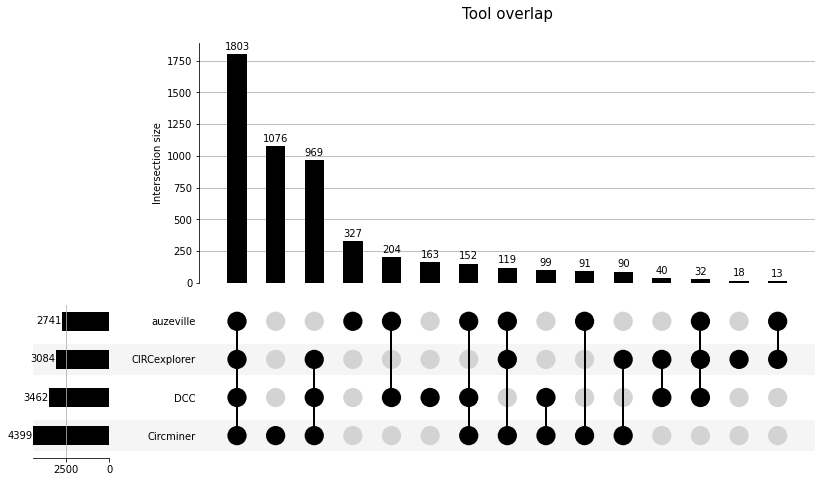

In [15]:
support = get_support(HeLa["HeLaR+"])
fig = plt.figure(figsize=(100, 20))
upset = UpSet(support, subset_size='count', sort_by="cardinality", show_counts='%d', element_size=55)
upset.plot(fig = fig)
temp = plt.title("Tool overlap\n",fontsize=15)

### HeLaR- Annotations provided by DCC

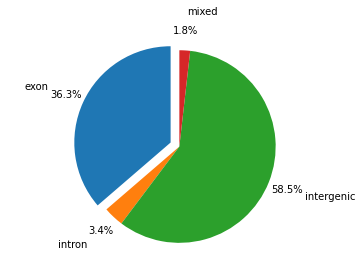

In [16]:
circrnas = get_dcc_annotation(HeLa["HeLaR-"], "circrnas/HeLaRminus/dcc/CircCoordinates")
annot_pie(circrnas)

### HeLaR+ Annotations provided by DCC

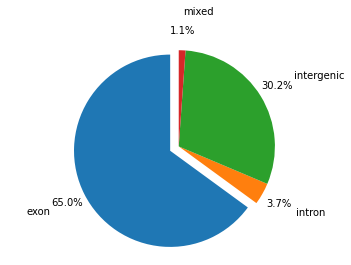

In [17]:
circrnas = get_dcc_annotation(HeLa["HeLaR+"], "circrnas/HeLaRplus/dcc/CircCoordinates")
annot_pie(circrnas)

## Hs68 cell line

In [26]:
tools = ["Circminer", "CIRCexplorer", "DCC", "auzeville"]
treatments = ["Hs68R-", "Hs68R+"]
min_ccr = 3
Hs68 = defaultdict()
Hs68["Hs68R-"] = getRNaseCirc("SRR444975",  tools, min_ccr=min_ccr)
Hs68["Hs68R+"] = getRNaseCirc("SRR445016",  tools, min_ccr=min_ccr)

Reading circrnas/SRR444975/circminer.out
Reading circrnas/SRR444975/circexplorer.out
Reading circrnas/SRR444975/dcc.out
Reading circrnas/SRR444975/auzeville.out
Reading circrnas/SRR445016/circminer.out
Reading circrnas/SRR445016/circexplorer.out


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  


Reading circrnas/SRR445016/dcc.out
Reading circrnas/SRR445016/auzeville.out


In [27]:
calls = defaultdict(list)
for condition in treatments:
    for tool in tools:
        calls[condition].append(len(Hs68[condition][tool]))
calls['tool'] = tools
calls.update(get_not_depleted(Hs68, tools, "Hs68R+", "Hs68R-"))

#### Detailed comparison or circ detection tools on Hs68 RNAse-	Hs68 RNAse+

In [28]:
pd.DataFrame(calls).set_index("tool")

,Hs68R-,Hs68R+,Not depleted,Not depleted (%)
tool,,,,
Circminer,2615,18688,2112,0.807648
CIRCexplorer,1637,15455,1312,0.801466
DCC,2102,16752,1520,0.723121
auzeville,7460,25673,1470,0.254722


### Tool overlap for Hs68-

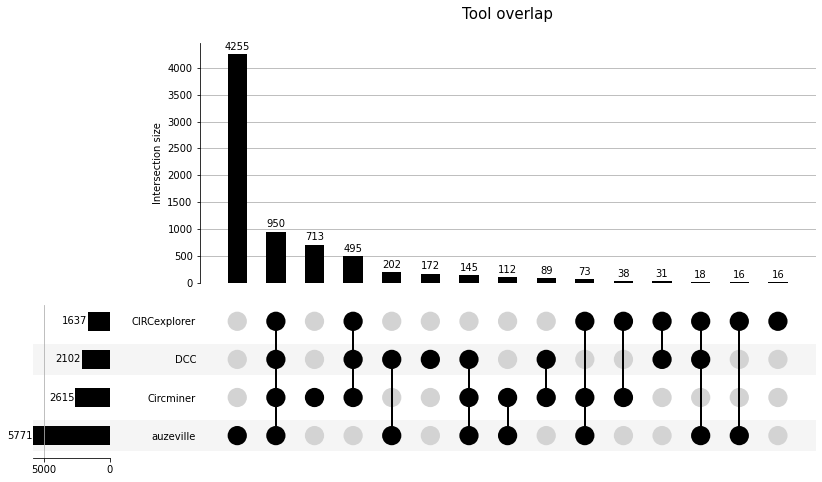

In [29]:
support = get_support(Hs68["Hs68R-"])
fig = plt.figure(figsize=(100, 20))
upset = UpSet(support, subset_size='count', sort_by="cardinality", show_counts='%d', element_size=55)
upset.plot(fig = fig)
temp = plt.title("Tool overlap\n",fontsize=15)

### Tool overlap for Hs68+

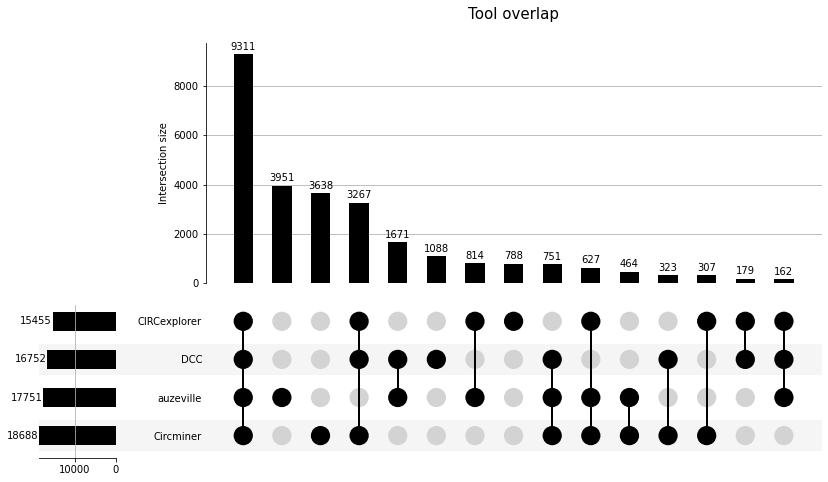

In [31]:
support = get_support(Hs68["Hs68R+"])
fig = plt.figure(figsize=(100, 20))
upset = UpSet(support, subset_size='count', sort_by="cardinality", show_counts='%d', element_size=55)
upset.plot(fig = fig)
temp = plt.title("Tool overlap\n",fontsize=15)

### Hs68- Annotations provided by DCC

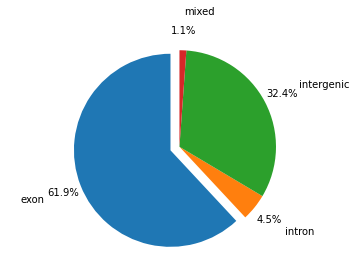

In [32]:
circrnas = get_dcc_annotation(Hs68["Hs68R-"], "circrnas/SRR444975/dcc/CircCoordinates")
annot_pie(circrnas)

### Hs68+ Annotations provided by DCC

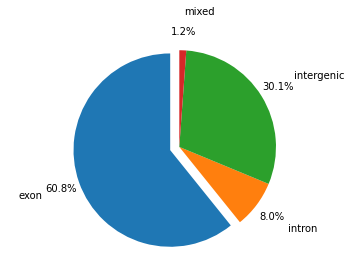

In [33]:
circrnas = get_dcc_annotation(Hs68["Hs68R+"], "circrnas/SRR445016/dcc/CircCoordinates")
annot_pie(circrnas)

In [34]:
dcc = get_dcc("circrnas/SRR445016/dcc/CircRNACount")
dcc_annot = pd.read_csv("circrnas/SRR445016/dcc/CircCoordinates", sep="\t")
dcc_annot = dcc_annot.rename(columns={"Chr": "chrom", "Start": "start", "End": "end"})
                     
dcc_keys = []
for index, row in dcc.iterrows():
    circ_key = set_key(row)
    dcc_keys.append(circ_key)
dcc['key'] = dcc_keys
annot_keys = []
for index, row in dcc_annot.iterrows():
    circ_key = set_key(row)
    annot_keys.append(circ_key)
dcc_annot['key'] = annot_keys
circrnas = dcc.join(dcc_annot, lsuffix='_caller', rsuffix='_other')

In [35]:
circrnas_annot = []
for index, row in circrnas.iterrows():
    annot = row['Start-End Region']
    reannot = "-".join(sorted(annot.split('-')))
    if ("intron" in annot or "exon" in annot) and "intergenic" in annot:
        reannot = "mixed"
    elif "intron" in annot:
        reannot = "intron"
    elif "intergenic" in annot:
        reannot = "intergenic"
    elif "exon" in annot:
        reannot = "exon"
    circrnas_annot.append(reannot)
circrnas['annotation'] = circrnas_annot

In [36]:
def annot_pie_data(circrnas, cutoff=1):
    rnas = circrnas[circrnas['nccr']>cutoff]
    sizes = rnas.groupby("annotation").size() 
    new_index = ['exon', 'intron', 'intergenic', 'mixed']
    sizes = sizes.reindex(index=new_index)
    pie_sizes = sizes.values
    return pie_sizes

## Impact of nccr on annotations

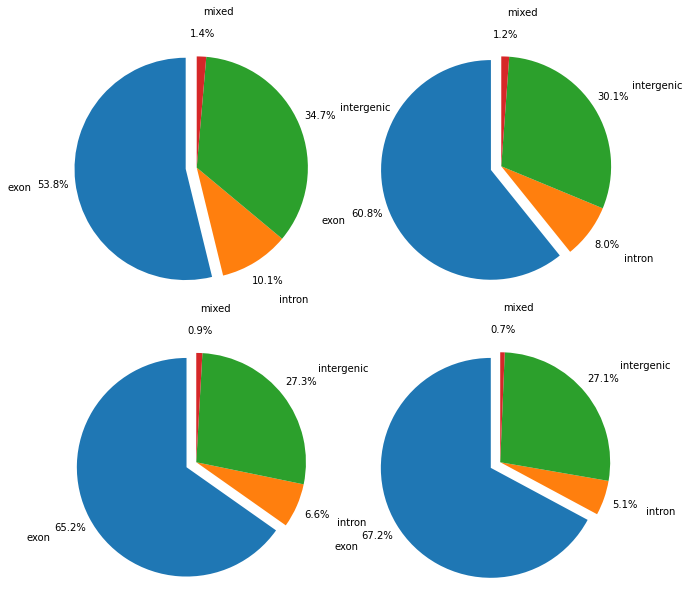

In [37]:
import matplotlib.pyplot as plt

explode = (0.1, 0, 0, 0)
labels = ['exon', 'intron', 'intergenic', 'mixed']

all_circ = annot_pie_data(circrnas)
cutoff2 = annot_pie_data(circrnas, cutoff=2)
cutoff4= annot_pie_data(circrnas, cutoff=4)
cutoff8= annot_pie_data(circrnas, cutoff=8)

fig1, axs = plt.subplots(2,2, figsize=(10, 10))
axs[0, 0].pie(all_circ, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90, labeldistance=1.4, pctdistance=1.2)
axs[0, 0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

axs[0, 1].pie(cutoff2, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90, labeldistance=1.4, pctdistance=1.2)
axs[0, 1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
axs[1, 0].pie(cutoff4, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90, labeldistance=1.4, pctdistance=1.2)
axs[1, 0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
axs[1, 1].pie(cutoff8, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90, labeldistance=1.4, pctdistance=1.2)
axs[1, 1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
#fig1.suptitle("Annotations", fontsize=14)
plt.show()